Run this cell load the autoreload extension. This allows us to edit .py source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [ ]:
%load_ext autoreload
%autoreload 2

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Locating the path to the project

In [ ]:
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Predictive_Maintenance_Bearings'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)

print(os.listdir(GOOGLE_DRIVE_PATH))

['__pycache__', '.ipynb_checkpoints', 'Back', 'preprocessing', 'data', 'plot3d.xlsx', 'Models', 'Results', 'transfer_learning.py', 'cnn_architecture.py', 'Inference.ipynb', 'Source_mixed12k.pth', 'Source_Network.ipynb', 'mmd.py', 'optimize.py', 'MMDclassify_Source_norm_DA_TD_Finetune_last_layer_mixed12k.pth']


In [ ]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import torch
if torch.cuda.is_available:
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings')

Good to go!


In [ ]:
import torchvision
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
from torchvision import datasets, transforms
from transfer_learning import TransferLearningModel


Load pretrained model.

In [ ]:
from cnn_architecture import CNN_Architecture

DEVICE = torch.device("cuda")
PATH = os.path.join(GOOGLE_DRIVE_PATH, 'Source_mixed12k.pth')
# Model for Target Domain
model_pretrained = CNN_Architecture(dtype=torch.float32, device=DEVICE)
# Model for MMD
source_model = CNN_Architecture(dtype=torch.float32, device=DEVICE)

model_pretrained = model_pretrained.to(DEVICE)
source_model = source_model.to(DEVICE)


Computing the mean and standard deviation of our dataset

In [ ]:
import multiprocessing

torch.manual_seed(0)

data_transforms = {
    'Train': transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.RandomAdjustSharpness(1),
                transforms.ToTensor(),
                transforms.Normalize([0., 0., 0.], [1., 1., 1.])
            ])
        }

data_dir = os.path.join(GOOGLE_DRIVE_PATH, 'data/ims_data/data/')
# print(os.listdir(data_dir + '/Train'))
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['Train']}

NUM_WORKERS = multiprocessing.cpu_count()
BATCH_SIZE = 4

image_dataloader = torch.utils.data.DataLoader(dataset = image_datasets['Train'], batch_size = BATCH_SIZE, 
                                               num_workers = NUM_WORKERS, pin_memory = True, shuffle = False)

In [ ]:
# Compute Mean and Std's
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])

for i, data in tqdm(enumerate(image_dataloader), total=len(image_dataloader)):
    images, labels = data
    psum    += images.sum(axis = [0, 2, 3])
    psum_sq += (images ** 2).sum(axis = [0, 2, 3])

image_size = 224
count = len(image_datasets['Train'])*image_size*image_size
print(psum)
print(psum_sq)
print(count)

  0%|          | 0/18 [00:00<?, ?it/s]

tensor([ 876920.6250,  847523.4375, 1753411.0000])
tensor([214749.2656, 225789.1719, 858243.0000])
3612672


In [ ]:
total_mean = psum/count
total_var = (psum/count) - (total_mean**2)
total_std = torch.sqrt(total_var)

print(f"Mean of the dataset is :                {total_mean}")
print(f"Standard Deviation for the dataset is : {total_std}")

Mean of the dataset is :                tensor([0.2427, 0.2346, 0.4854])
Standard Deviation for the dataset is : tensor([0.4287, 0.4237, 0.4998])


Target Mean and STD <br>
Mean - [0.2427, 0.2346, 0.4854] <br>
Std  - [0.4287, 0.4237, 0.4998] <br>

Source Domain Mean and Std - If you want to use target domain stats please comment the cell below


In [ ]:
total_mean = torch.tensor([0.2389, 0.2519, 0.4697])
total_std = torch.tensor([0.4264, 0.4341, 0.4991])

Train and evaluate

On GPU this will take about half the time compared to previous scenario. This is expected as gradients don’t need to be computed for most of the network. However, forward does need to be computed.

In [ ]:
torch.manual_seed(0)

# Data Augmentations performed - extremely basic just resizing to image dimension to 3x224x224 and sharpening the images to ensure image resolution is not lost
data_transforms = {
    'Train': transforms.Compose([
             transforms.Resize((224, 224)),
             transforms.RandomAdjustSharpness(1),
             transforms.ToTensor(),
             transforms.Normalize(total_mean, total_std)
    ]),
    'Val': transforms.Compose([
           transforms.Resize((224, 224)),
           transforms.RandomAdjustSharpness(1),
           transforms.ToTensor(),
           transforms.Normalize(total_mean, total_std)
    ]),
    'Test': transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomAdjustSharpness(1),
            transforms.ToTensor(),
            transforms.Normalize(total_mean, total_std)
    ])
}

# Load data from disk

NUM_WORKERS = multiprocessing.cpu_count()
BATCH_SIZE = 4

data_dir = os.path.join(GOOGLE_DRIVE_PATH, 'data/ims_data/data/')
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['Train', 'Val', 'Test']}

# Training Dataloader
train_dataloader = torch.utils.data.DataLoader(dataset = image_datasets['Train'], batch_size = BATCH_SIZE, 
                                               num_workers = NUM_WORKERS, pin_memory = True, shuffle = True)
# Validation Dataloader
val_dataloader = torch.utils.data.DataLoader(dataset = image_datasets['Val'], batch_size = BATCH_SIZE, 
                                             num_workers = NUM_WORKERS, pin_memory = True, shuffle = False)
# Test Dataloader
test_dataloader = torch.utils.data.DataLoader(dataset = image_datasets['Test'], batch_size = BATCH_SIZE, 
                                              num_workers = NUM_WORKERS, pin_memory = True, shuffle = False)

path_classes_train = {x: len(os.listdir(os.path.join(data_dir, 'Train/'+ x))) for x in ['Faulty', 'Healthy']}
path_classes_val = {x: len(os.listdir(os.path.join(data_dir, 'Val/'+ x))) for x in ['Faulty', 'Healthy']}
path_classes_test = {x: len(os.listdir(os.path.join(data_dir, 'Test/'+ x))) for x in ['Faulty', 'Healthy']}

train_loader_iter = iter(train_dataloader)
image, batches = next(train_loader_iter)
dataset_sizes = {x: len(image_datasets[x]) for x in ['Train', 'Val', 'Test']}
class_names = image_datasets['Train'].classes

B, C, H, W = image.shape[0], image.shape[1], image.shape[2], image.shape[3]

print(f"path classes Train          : {path_classes_train}" )
print(f"path classes Val            : {path_classes_val}")
print(f"path classes Test           : {path_classes_test}")
print(f"image has shape (B, C, H, W): {image.shape}")
print(f"image batch has shape       : {batches.shape}")
print(f"dataset_sizes               : {dataset_sizes}")
print(f"Class names                 : {class_names}")

path classes Train          : {'Faulty': 36, 'Healthy': 36}
path classes Val            : {'Faulty': 4, 'Healthy': 4}
path classes Test           : {'Faulty': 369, 'Healthy': 369}
image has shape (B, C, H, W): torch.Size([4, 3, 224, 224])
image batch has shape       : torch.Size([4])
dataset_sizes               : {'Train': 72, 'Val': 8, 'Test': 738}
Class names                 : ['Faulty', 'Healthy']


Load pre-trained model, if not using MMD comment out everything with source model

In [ ]:
checkpoint = torch.load(PATH)
model_pretrained.load_state_dict(checkpoint['model_state_dict'])
source_model.load_state_dict(checkpoint['model_state_dict'])

# For Source model keep all params frozen
for param in source_model.parameters():
  param.requires_grad = False

# Target Model -  Finetune or Freeze training
for param in model_pretrained.parameters():
    param.requires_grad = True

The cell below is essentially used to select the number of layers to re-initialize for transfer learning. Refer to CNN Architecture to check the network architecture if required

In [ ]:
num_ftrs = model_pretrained.classify[0].in_features
print(num_ftrs)
hidden_dim = 120
model_pretrained.classify = nn.Sequential(nn.Linear(num_ftrs, hidden_dim),
                                          nn.ReLU(inplace=True),
                                          nn.Dropout(p=0.2),
                                          nn.Linear(hidden_dim, hidden_dim),
                                          nn.ReLU(inplace=True),
                                          nn.Dropout(p=0.2),
                                          nn.Linear(hidden_dim, 2))

1605632


In [ ]:
import time
from optimize import SaveBestModel, train_model_target, train_model, val_model

torch.manual_seed(0)

DEVICE = torch.device("cuda")

source_model = source_model.to(DEVICE)
tl_model = model_pretrained.to(DEVICE)


# Loss Criterion and Optimizer for the Model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(tl_model.parameters(), lr=1e-5, betas=(0.9, 0.999), 
                       weight_decay= 1e-4, amsgrad=False)

# initialize SaveBestModel class
save_best_model = SaveBestModel(model=tl_model, optimizer=optimizer, criterion=criterion,
                                path = GOOGLE_DRIVE_PATH)

NUM_EPOCHS = 50

# Used for plotting loss and acc
train_loss, val_loss = [], []
train_acc, val_acc = [], [] 

# Main Training and Validation Loop
for epoch in range(NUM_EPOCHS):
    print(f'Epoch {epoch+1} of {NUM_EPOCHS}')
    train_epoch_loss, train_epoch_acc = train_model_target(source_model, tl_model, train_dataloader, optimizer, criterion, DEVICE)
    val_epoch_loss, val_epoch_acc = val_model(tl_model, val_dataloader, criterion, DEVICE)

    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    train_acc.append(train_epoch_acc)
    val_acc.append(val_epoch_acc)

    print(f'Training loss: {train_epoch_loss:.3f} and Training Acc: {train_epoch_acc:.3f}')
    print(f'Val loss: {val_epoch_loss:.3f} and Val Acc: {val_epoch_acc:.3f}')

    best_model = save_best_model.best_loss(val_epoch_loss, val_epoch_acc, epoch)

    print('-'*50)
    
    if val_epoch_acc == 100.0:
      break

print('Finished Training')

194,243,618 total trainaible parameters.
Epoch 1 of 50
Training


  0%|          | 0/18 [00:00<?, ?it/s]

Validation


  0%|          | 0/2 [00:00<?, ?it/s]

Training loss: 0.067 and Training Acc: 100.000
Val loss: 0.589 and Val Acc: 75.000

Best validation loss and acc: 0.5892601162195206

Saving best model for epoch: 1

file saved to drive/My Drive/Predictive_Maintenance_Bearings/MMDclassify_Source_norm_DA_TD_Finetune_classify_layers_mixed12k.pth
--------------------------------------------------
Epoch 2 of 50
Training


  0%|          | 0/18 [00:00<?, ?it/s]

Validation


  0%|          | 0/2 [00:00<?, ?it/s]

Training loss: 0.209 and Training Acc: 97.222
Val loss: 0.082 and Val Acc: 100.000

Best validation loss and acc: 0.08187641762197018

Saving best model for epoch: 2

file saved to drive/My Drive/Predictive_Maintenance_Bearings/MMDclassify_Source_norm_DA_TD_Finetune_classify_layers_mixed12k.pth
--------------------------------------------------
Finished Training


Plotting the Train and Validation Loss

<function matplotlib.pyplot.show(close=None, block=None)>

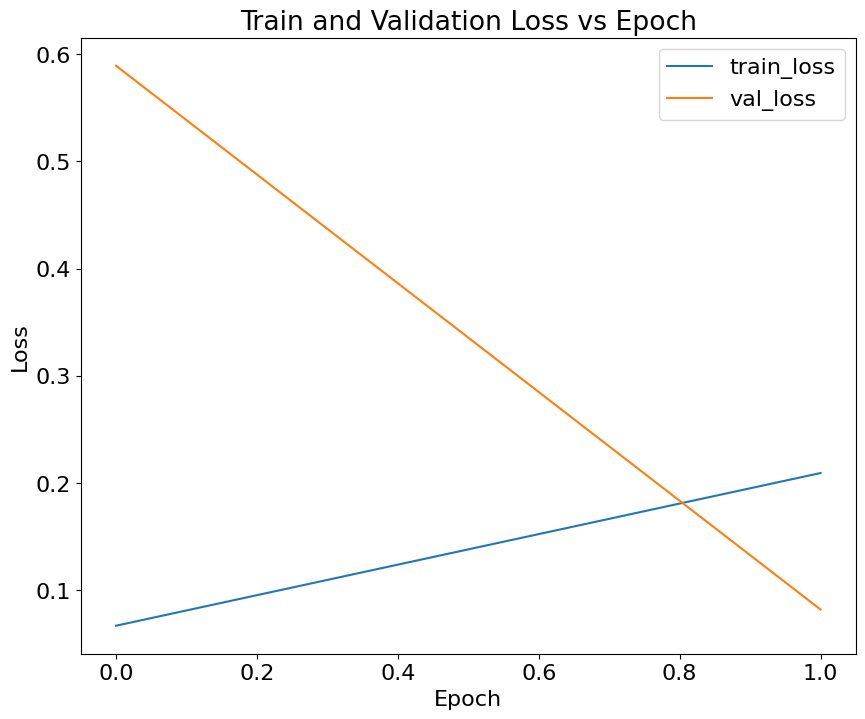

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10.0, 8.0)  # set default size of plots
plt.rcParams["font.size"] = 16
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

plt.plot(train_loss, label='train_loss')
plt.plot(val_loss, label='val_loss')
plt.title('Train and Validation Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join(GOOGLE_DRIVE_PATH, 'Results/DA_classify_Target_Domain_mixed12k_few_shot_finetune_classify_layers_retrained_source_norm.png'))
plt.show

**Inference Target**

Do not run inference without completing training and validation.


In [ ]:
from cnn_architecture import CNN_Architecture

torch.manual_seed(0)

DEVICE = torch.device("cuda")
# Path to model parameters
PATH = os.path.join(GOOGLE_DRIVE_PATH, 'MMDclassify_Source_norm_DA_TD_Finetune_classify_layers_mixed12k.pth')
test_model = CNN_Architecture(input_dims=(C, H, W), num_classes=2,
                            dtype=torch.float32, device=DEVICE)

test_model = test_model.to(DEVICE)
# Load the model
checkpoint = torch.load(PATH)
test_model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

The Next two cells are just to check whether inference is working and to get a visual output of the results.

GroundTruth:  Faulty Faulty Faulty Faulty


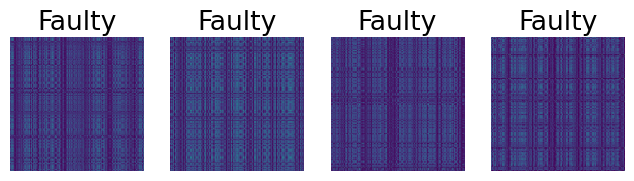

In [ ]:
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

classes = ['Faulty', 'Healthy']
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

mean = total_mean
std  = total_std
for i in range(images.shape[0]):
  im = images[i, :, :, :]
  im = im*std.view(3,1,1) + mean.view(3,1,1)
  plt.subplot(2, 5, i+1).set_title(f'{classes[labels[i]]}')
  plt.imshow(torch.permute(im, (1,2,0)))
  plt.axis('off')

In [ ]:
torch.manual_seed(0)

test_model.eval()
images = images.to(DEVICE)
outputs = test_model(images)

_, predicted = torch.max(outputs, 1)
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'for j in range(len(images))))

Predicted:  Faulty Faulty Faulty Faulty


The cell below performs inference on the test set based on the model parameters trained upon

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
torch.manual_seed(0)

with torch.no_grad():
  for data in test_dataloader:
        images, labels = data
        # calculate outputs by running images through the network
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = test_model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(f'Accuracy of the network with test images of: {100 * correct / total} %')

Accuracy of the network with test images of: 82.79132791327913 %


<b> Transfer Learning Test Results </b>
<br>
Baseline Model Accuracy - 93.023 % <br>
TL Freeze Last Layer Retrain, Norm - Target : 57.319% <br>
TL Freeze Classify Layers Retrain, Norm - Target : 84.28 % <br>
TL Finetune Last Layer Retrain, Norm - Target : 76.2 % <br>
TL Finetune Classify Layers Retrain, Norm - Target : 85.23 % <br>
TL Finetune Classify Layers Retrain, Norm - Source : 84.42% <br>

MMD on Last Classify Layer
DA TL Freeze Last Layer Retrained, Norm - Target : 43.9 % <br>
DA TL Freeze Classify Layers Retrained, Norm - Target : 78.18 % <br>
DA TL Finetune Last Layer Retrain, Norm - Target : 77.018 % <br>
DA TL Finetune Classify Layers Retrained, Norm - Target : 85.23 % <br> 
DA TL Finetune Classify Layers Retrained, Norm - Source : 88.75 % <br>

MMD on ALL Classify Layers <br>
Linear Layers Finetune Last Layer Retrain, Norm - Source : 83.604 % <br>
Linear Layers Finetune Classify Layers Retrain, Norm - Source : 82.79 % <br>